# RESULTS
Here I report the resulsts of the training procedure.

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
prms = {'L' : 10,                # length of spin chain
        'sites' : [0, 1],        # sites of the subsystem S spins
        'omega' : 1,             # Rabi frequency
        'beta' : 0.01,           # inverse temperature
        'potential' : 0.1,       # interaction of subsystem's S spins
        'potential_' : None,     # interaction of bath spins, if None same as potential
        'T' : 10,                # total time for the evolution
        'dt' : 0.01,             # interval every which save the data
        'cutoff' : 1e-8,         # cutoff for TEBD algorithm
        'im_cutoff' : 1e-10,      # cutoff for TEBD algorithm, img t-e
        'tolerance' : 1e-3,      # Trotter tolerance for TEBD algorithm
        'verbose' : True,        # verbosity of the script
        'num_traj' : 20,         # how many trajectories to do
        # file to save the data
        'fname' : './data/data_tebd.hdf5'
        }

ml_params = {'model_dir': './data/trained_model', # folder where the metadata of the training are stored
             'validation_split' : 0.8,
             'batch_size': 256,
             #'batches_per_epoch': 256,
             'n_epochs': 20,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt' : 0.01
                 },
             }

### Generate some data

In [3]:
### TEBD
from models import SpinChain

sys_prms = prms.copy()
sys_prms.pop('sites')
sys_prms.pop('potential_')
sys_prms.pop('num_traj')
sys_prms.pop('fname')
sys_prms['verbose'] = False

# evolution of the spin chain
system = SpinChain(**sys_prms)
system.thermalize()
system.evolve(seed=33)

results = system.return_results()

t=9.99, max-bond=24: 100%|################################################################################################################################| 1000/1000 [02:39<00:00,  6.29it/s]


In [ ]:
### EXACT
from models import SpinChain_ex

sys_prms = prms.copy()
sys_prms.pop('sites')
sys_prms.pop('potential_')
sys_prms.pop('num_traj')
sys_prms.pop('fname')
sys_prms['verbose'] = False
sys_prms.pop('cutoff')
sys_prms.pop('im_cutoff')
sys_prms.pop('tolerance')
sys_prms.pop('verbose')
# I simulate for longer times, I use it later
sys_prms['T'] = 20

# evolution of the spin chain
system_ex = SpinChain_ex(**sys_prms)
system_ex.evolve(seed=33)

results_ex = system_ex.return_results()

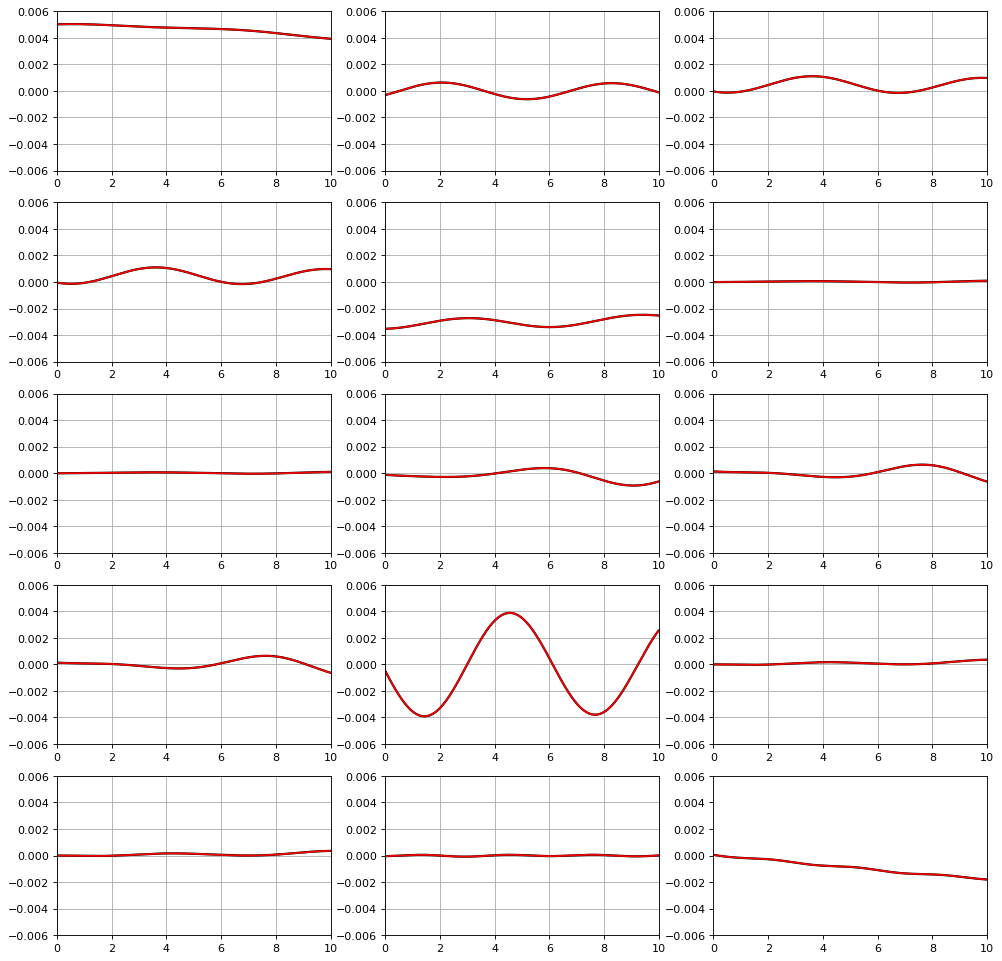

In [43]:
t = np.arange(0, 10, prms['dt'])

rows= 5
columns = 3

fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
plt.setp(axs, xlim=(0,10), ylim=(-0.006, 0.006))

for i in range(rows):
    for j in range(columns):
        #if i == rows-1 & j == columns-1:
        #    continue
        axs[i, j].plot(t, [results_ex[k][(columns-1)*i+j] for k in range(len(t))], label='Exact', color='k', linewidth=2)
        axs[i, j].plot(t, [results[k][(columns-1)*i+j] for k in range(len(t))], label='TEBD', color='r')
        axs[i, j].grid()

#plt.legend()
plt.grid()

### Import the model

In [4]:
from ml.classes import MLLP

name = 'model_L_' + str(prms['L']) + \
        '_V_' + str(int(prms['potential']*1e3)).zfill(4) + \
        '_beta_' + str(int(prms['beta']*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

my_file = Path('./data/trained_model/' + name)
if not my_file.is_file():
    raise Exception('File do not exists!')

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(my_file))

<All keys matched successfully>

In [11]:
for idx, m in enumerate(model.modules()):
    print(idx, '->', m)

0 -> MLLP(
  (MLP): exp_LL(
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=225, bias=True)
    )
  )
)
1 -> exp_LL(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=225, bias=True)
  )
)
2 -> ModuleList(
  (0): Linear(in_features=1, out_features=225, bias=True)
)
3 -> Linear(in_features=1, out_features=225, bias=True)


In [13]:
print(model)

MLLP(
  (MLP): exp_LL(
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=225, bias=True)
    )
  )
)


### Generate the dynamics with the model

In [5]:
ml_dyn = model.generate_trajectory(v_0=np.array(results[0]), T=10)

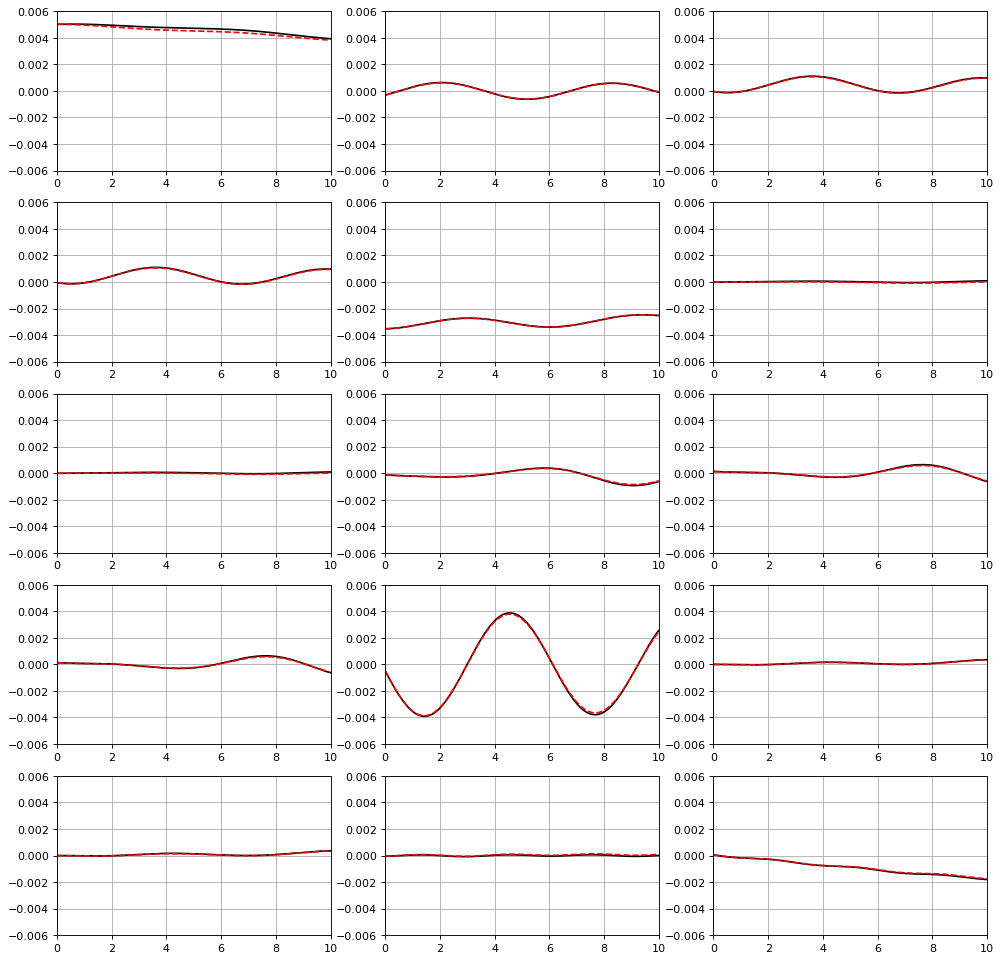

In [6]:
t = np.arange(0, 10, prms['dt'])

rows= 5
columns = 3

fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
plt.setp(axs, xlim=(0,10), ylim=(-0.006, 0.006))

for i in range(rows):
    for j in range(columns):
        #if i == rows-1 & j == columns-1:
        #    continue
        axs[i, j].plot(t, [results[k][(columns-1)*i+j] for k in range(len(t))], label='Simulation', color='k')
        axs[i, j].plot(t, [ml_dyn[k][(columns-1)*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
        axs[i, j].grid()
axs[4, 2].grid()
#plt.legend()
plt.grid()

fig = plt.gcf()
plt.show()

#fig.savefig('../pictures/first_model.pdf', dpi=80)

## Further times

In [7]:
ml_dyn = model.generate_trajectory(v_0=np.array(results[0]), T=20)

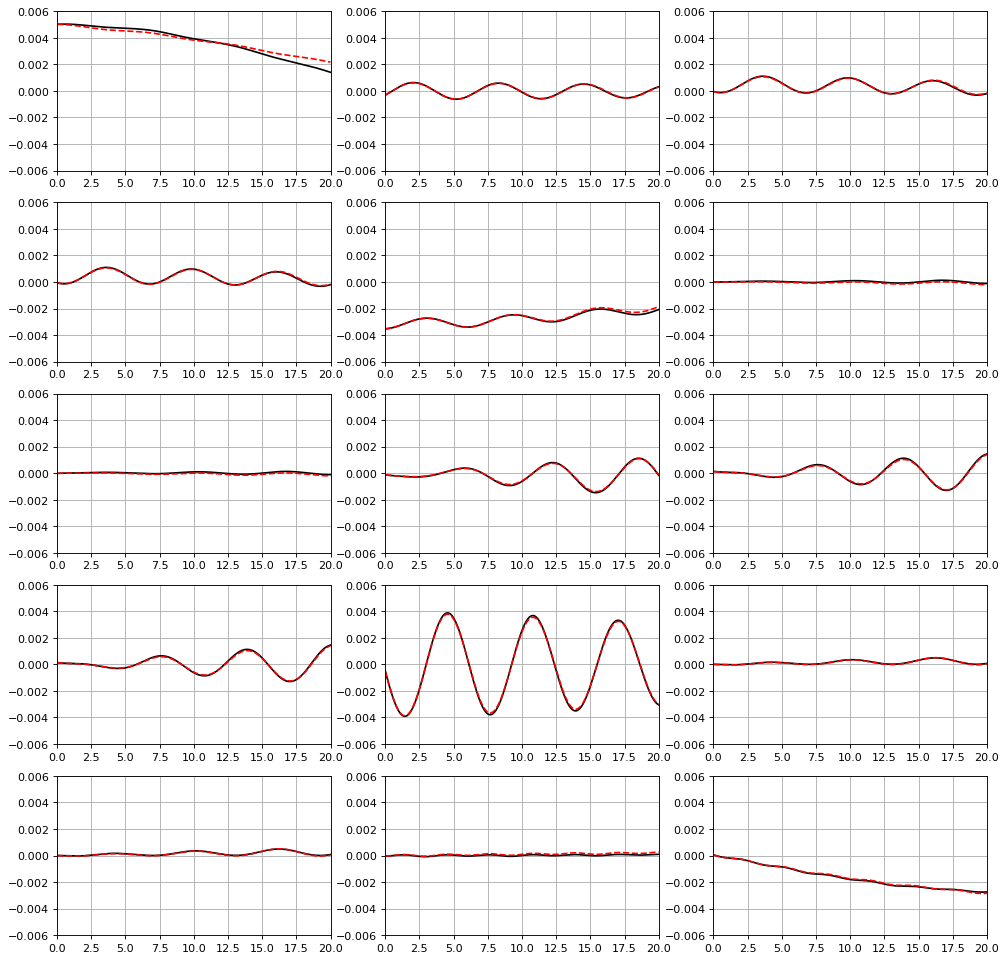

In [39]:
t = np.arange(0, 20, prms['dt'])

rows= 5
columns = 3

fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
plt.setp(axs, xlim=(0,20), ylim=(-0.006, 0.006))

for i in range(rows):
    for j in range(columns):
        #if i == rows-1 & j == columns-1:
        #    continue
        axs[i, j].plot(t, [results_ex[k][(columns-1)*i+j] for k in range(len(t))], label='Simulation', color='k')
        axs[i, j].plot(t, [ml_dyn_long[k][(columns-1)*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
        axs[i, j].grid()
axs[4, 2].grid()
#plt.legend()
plt.grid()

fig = plt.gcf()
plt.show()

#fig.savefig('../pictures/first_model.pdf', dpi=80)

### Import the data from the training

In [95]:
from ml.classes import CustomDatasetFromHDF5
gname = 'cohVec_L_' + str(10) + \
        '_V_' + str(int(0.1*1e3)).zfill(4) + \
        '_beta_' + str(int(0.01*1e3)).zfill(4) + \
        '_dt_' + str(int(0.01*1e3)).zfill(4)

validation_split = 0.8
batch_size = 256

dataset = CustomDatasetFromHDF5('./data/data_tebd_1.hdf5', gname)

In [96]:
N = 1
data = [float(dataset[i][0].detach().numpy()[1]) for i in range(999*(N-1), 999*N)]
#data_ = [float(dataset[i][1].detach().numpy()[1]) for i in range(999*(N-1), 999*N)]

ml_dyn = [np.array(dataset[0][0])]

X = torch.tensor(ml_dyn[0])

for i in range(len(results)-1):
    with torch.no_grad():
        y = model(X.float())

        ml_dyn.extend([y.numpy()])
        X = y

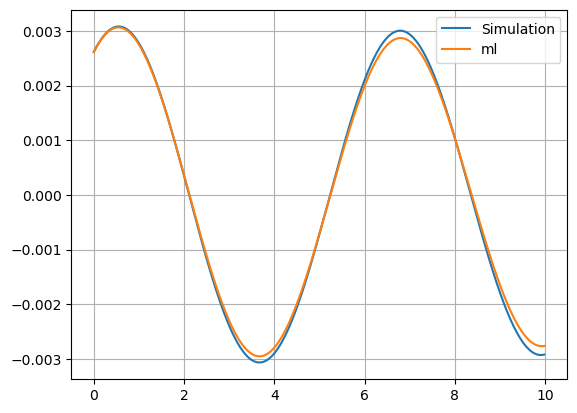

In [97]:
keys = [1]

t = np.arange(0, 10, prms['dt'])

for key in keys:
    plt.plot(t[:-1], data, label='Simulation')
    plt.plot(t, [ml_dyn[i][key] for i in range(len(t))], label='ml')

plt.legend()
plt.grid()